In [1]:
%matplotlib inline


# Audio Data Augmentation

``torchaudio``, ses verilerini artırmak için çeşitli yollar sağlar.

Bu eğitimde, efektleri, filtreleri uygulamanın bir yolunu inceliyoruz.
RIR (room impulse response) ve codecs.

Sonunda, telefondaki gürültülü konuşmayı temiz konuşmadan sentezliyoruz.


In [2]:
import torch
import torchaudio
import torchaudio.functional as F

print(torch.__version__)
print(torchaudio.__version__)

1.13.1+cu116
0.13.1+cu116


## Hazırlık

İlk olarak, modülleri içe aktarıyoruz ve bu eğitimde kullandığımız ses varlıklarını indiriyoruz.



In [3]:
import math

from IPython.display import Audio
import matplotlib.pyplot as plt

from torchaudio.utils import download_asset

SAMPLE_WAV = download_asset("tutorial-assets/steam-train-whistle-daniel_simon.wav")
SAMPLE_RIR = download_asset("tutorial-assets/Lab41-SRI-VOiCES-rm1-impulse-mc01-stu-clo-8000hz.wav")
SAMPLE_SPEECH = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042-8000hz.wav")
SAMPLE_NOISE = download_asset("tutorial-assets/Lab41-SRI-VOiCES-rm1-babb-mc01-stu-clo-8000hz.wav")

  0%|          | 0.00/427k [00:00<?, ?B/s]

  0%|          | 0.00/31.3k [00:00<?, ?B/s]

  0%|          | 0.00/53.2k [00:00<?, ?B/s]

  0%|          | 0.00/78.2k [00:00<?, ?B/s]

## Efekt uygulama ve filtreleme

`torchaudio.sox_effects`, ``sox`` içinde bulunanları Tensör nesnelerine ve dosya nesnesi ses kaynaklarına efektlerin doğrudan uygulanmasına izin verir:

Bunun için iki işlev vardır:

-  `torchaudio.sox_effects.apply_effects_tensor` tensore efekt uygulamak için.
-  `torchaudio.sox_effects.apply_effects_file` diğer ses kaynaklarına efektleri uygulamak için.

Her iki fonksiyon da formdaki efekt tanımlarını kabul eder.
``List[List[str]]``.
Bu çoğunlukla ``sox`` komutunun benzerdik, ancak küçük bir hatırlatma yapmak isteriz.
``sox`` bazı efektleri otomatik olarak eklerken, ``torchaudio`` bazılarını otomatik kaydetmez.

Mevcut efektlerin listesi için lütfen kontrol edin. [sox
belgeler](http://sox.sourceforge.net/sox.html).

**İpucu** Ses verilerinizi anında yüklemeniz ve yeniden örneklemeniz gerekirse,
o zaman `torchaudio.sox_effects.apply_effects_file` `rate` parametresi ile kullanabilirsiniz.


**Not** `torchaudio.sox_effects.apply_effects_file` 
dosya benzeri nesne veya yol benzeri nesneyi kabul eder.
`torchaudio.load`a benzer.
Ses formatı değiştirilemediğinde ses kaynağının formatını belirtmek için ``format`` argümanı kullanıp
dosya uzantısından veya başlığından çıkarsanarak, aynı işleve sahip bir işlev oluşturabiliriz.
**Not** Bu işlem türevlenebilir değildir.




In [4]:
# ses verimizi yükleyelim.
waveform1, sample_rate1 = torchaudio.load(SAMPLE_WAV)

# Efektleri tanımlayın
effects = [
    ["lowpass", "-1", "300"],  # apply single-pole lowpass filter
    ["speed", "0.8"],  # reduce the speed
    # This only changes sample rate, so it is necessary to
    # add `rate` effect with original sample rate after this.
    ["rate", f"{sample_rate1}"],
    ["reverb", "-w"],  # Reverbration gives some dramatic feeling
]

# efektleri uygulayalım
waveform2, sample_rate2 = torchaudio.sox_effects.apply_effects_tensor(waveform1, sample_rate1, effects)

print(waveform1.shape, sample_rate1)
print(waveform2.shape, sample_rate2)

torch.Size([2, 109368]) 44100
torch.Size([2, 136710]) 44100


Efektler uygulandıktan sonra çerçeve sayısı ve kanal sayısının orijinalinkinden farklı olduğunu unutmayın. Sesi dinleyelim.




In [5]:
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)

In [6]:
def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()

    num_channels, _ = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)

### Orjinal:




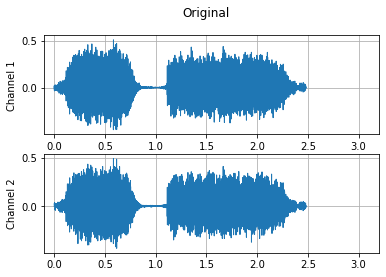

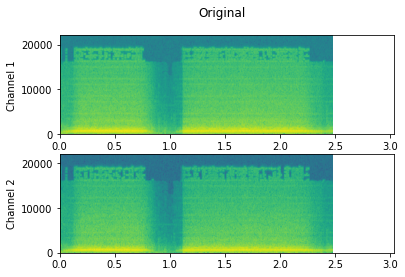

In [7]:
plot_waveform(waveform1, sample_rate1, title="Original", xlim=(-0.1, 3.2))
plot_specgram(waveform1, sample_rate1, title="Original", xlim=(0, 3.04))
Audio(waveform1, rate=sample_rate1)

### efekt uygulanmış hali:




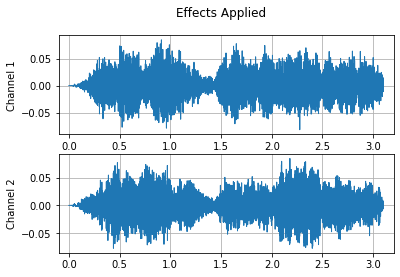

/usr/local/lib/python3.8/dist-packages/matplotlib/axes/_axes.py:7628: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


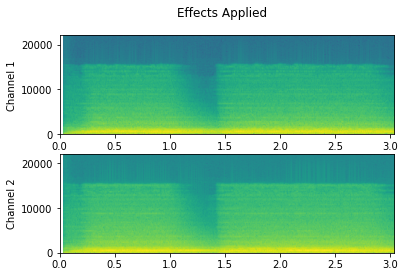

In [8]:
plot_waveform(waveform2, sample_rate2, title="Effects Applied", xlim=(-0.1, 3.2))
plot_specgram(waveform2, sample_rate2, title="Effects Applied", xlim=(0, 3.04))
Audio(waveform2, rate=sample_rate2)

Kulağa daha dramatik gelmiyor mu? :)))




## Oda yankılanmasını simüle etme

[Convolution
reverb](https://en.wikipedia.org/wiki/Convolution_reverb)_ sanki temiz ses çıkarmak için kullanılan tekniktir. Daha fazlası için linke göz atabilirsiniz.

Using Room Impulse Response (RIR), kullanarak mesela temiz konuşma yapabiliriz
sanki bir konferans odasında söylenmiş gibi.

Bu işlem için RIR verilerine ihtiyacımız var. Aşağıdaki veriler VOiCES'ten alınmıştır.
Ancak kendinizinkini kaydedebilirsiniz — sadece mikrofonunuzu açın
ve ellerini çırp.



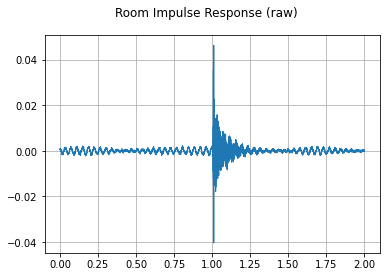

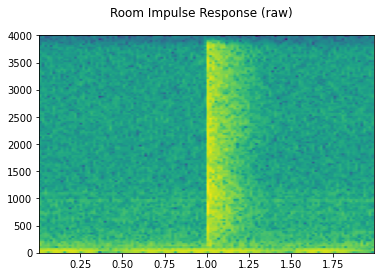

In [9]:
rir_raw, sample_rate = torchaudio.load(SAMPLE_RIR)
plot_waveform(rir_raw, sample_rate, title="Room Impulse Response (raw)")
plot_specgram(rir_raw, sample_rate, title="Room Impulse Response (raw)")
Audio(rir_raw, rate=sample_rate)

İlk olarak, RIR'ı temizlememiz gerekiyor. 



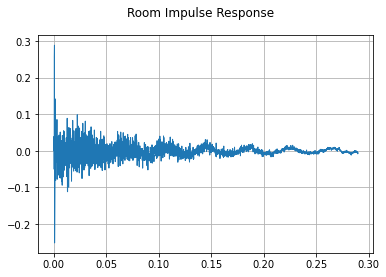

In [11]:
rir = rir_raw[:, int(sample_rate * 1.01) : int(sample_rate * 1.3)]
rir = rir / torch.norm(rir, p=2)
RIR = torch.flip(rir, [1])

plot_waveform(rir, sample_rate, title="Room Impulse Response")

Daha sonra, konuşma sinyalini RIR filtresiyle evriştiriyoruz.



In [12]:
speech, _ = torchaudio.load(SAMPLE_SPEECH)

speech_ = torch.nn.functional.pad(speech, (RIR.shape[1] - 1, 0))
augmented = torch.nn.functional.conv1d(speech_[None, ...], RIR[None, ...])[0]

### Orjinal:




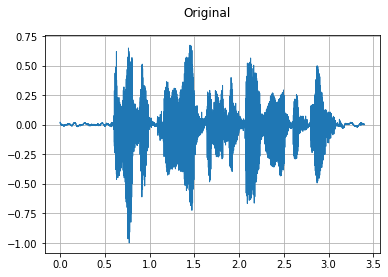

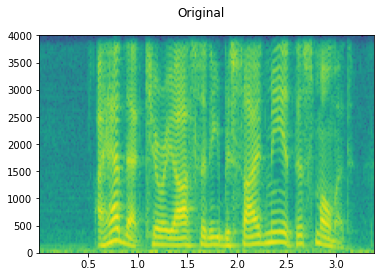

In [13]:
plot_waveform(speech, sample_rate, title="Original")
plot_specgram(speech, sample_rate, title="Original")
Audio(speech, rate=sample_rate)

### RIR uygulanmış hali:




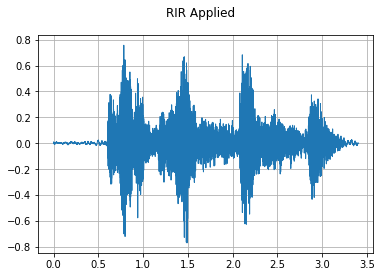

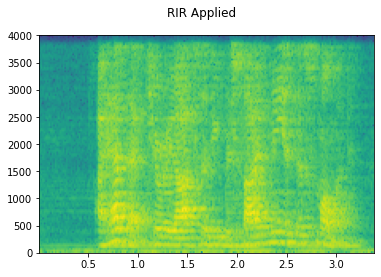

In [14]:
plot_waveform(augmented, sample_rate, title="RIR Applied")
plot_specgram(augmented, sample_rate, title="RIR Applied")
Audio(augmented, rate=sample_rate)

## Arka plan gürültüsü ekleme

Ses verilerine arka plan gürültüsü eklemek için, basitçe bir ses verilerini temsil eden Tensör gürültü Tensörü ekleyebilirsiniz.
.Bunu ayarlamak için yaygın bir yöntem şudur:
Gürültü yoğunluğu Sinyal-Gürültü Oranını (SNR) değiştiriyor.
[[wikipedia](https://en.wikipedia.org/wiki/Signal-to-noise_ratio)]

$$ \\mathrm{SNR} = \\frac{P_{signal}}{P_{noise}} $$

$$ \\mathrm{SNR_{dB}} = 10 \\log _{{10}} \\mathrm {SNR} $$




In [15]:
speech, _ = torchaudio.load(SAMPLE_SPEECH)
noise, _ = torchaudio.load(SAMPLE_NOISE)
noise = noise[:, : speech.shape[1]]

speech_rms = speech.norm(p=2)
noise_rms = noise.norm(p=2)

snr_dbs = [20, 10, 3]
noisy_speeches = []
for snr_db in snr_dbs:
    snr = 10 ** (snr_db / 20)
    scale = snr * noise_rms / speech_rms
    noisy_speeches.append((scale * speech + noise) / 2)

### Background noise:




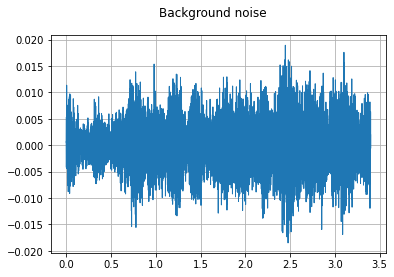

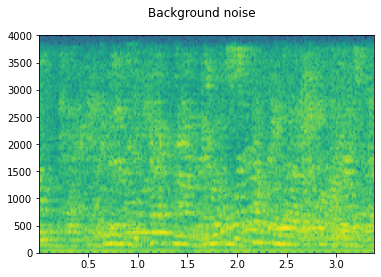

In [16]:
plot_waveform(noise, sample_rate, title="Background noise")
plot_specgram(noise, sample_rate, title="Background noise")
Audio(noise, rate=sample_rate)

### SNR 20 dB:




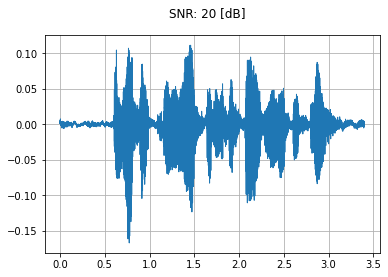

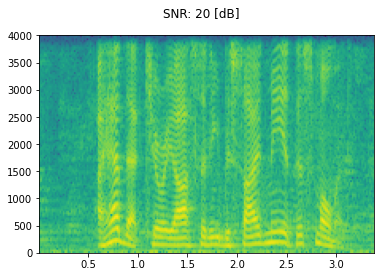

In [17]:
snr_db, noisy_speech = snr_dbs[0], noisy_speeches[0]
plot_waveform(noisy_speech, sample_rate, title=f"SNR: {snr_db} [dB]")
plot_specgram(noisy_speech, sample_rate, title=f"SNR: {snr_db} [dB]")
Audio(noisy_speech, rate=sample_rate)

### SNR 10 dB:




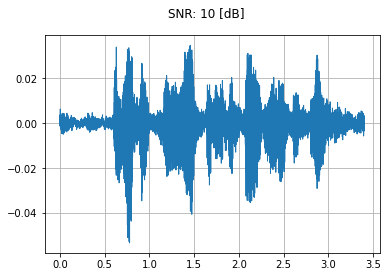

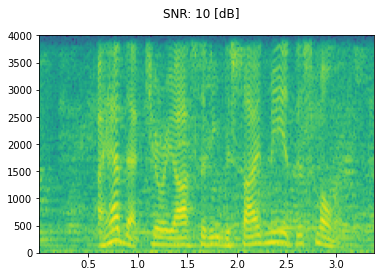

In [18]:
snr_db, noisy_speech = snr_dbs[1], noisy_speeches[1]
plot_waveform(noisy_speech, sample_rate, title=f"SNR: {snr_db} [dB]")
plot_specgram(noisy_speech, sample_rate, title=f"SNR: {snr_db} [dB]")
Audio(noisy_speech, rate=sample_rate)

### SNR 3 dB:




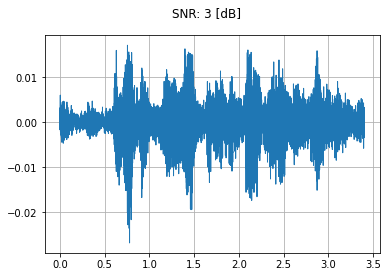

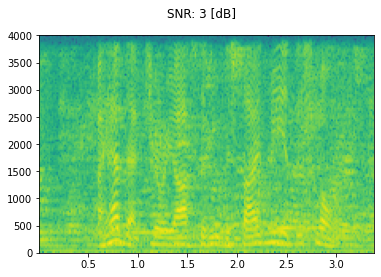

In [19]:
snr_db, noisy_speech = snr_dbs[2], noisy_speeches[2]
plot_waveform(noisy_speech, sample_rate, title=f"SNR: {snr_db} [dB]")
plot_specgram(noisy_speech, sample_rate, title=f"SNR: {snr_db} [dB]")
Audio(noisy_speech, rate=sample_rate)

## Tensör nesnesine codec bileşeni uygulama

`torchaudio.functional.apply_codec` codec bileşenlerini uygulayabilir
bir Tensör nesnesi.

**Not** Bu süreci dinlediğiniz de ayırt edemezsiniz.




In [20]:
waveform, sample_rate = torchaudio.load(SAMPLE_SPEECH)

configs = [
    {"format": "wav", "encoding": "ULAW", "bits_per_sample": 8},
    {"format": "gsm"},
    {"format": "vorbis", "compression": -1},
]
waveforms = []
for param in configs:
    augmented = F.apply_codec(waveform, sample_rate, **param)
    waveforms.append(augmented)

### Orjinal:




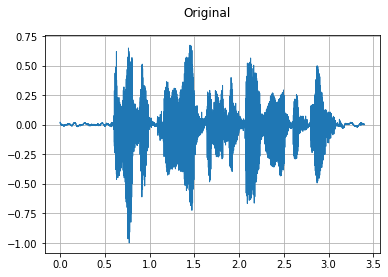

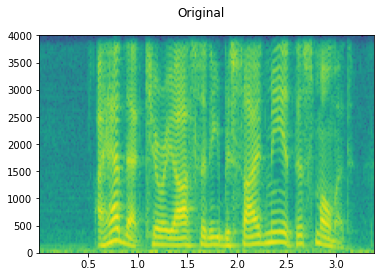

In [21]:
plot_waveform(waveform, sample_rate, title="Original")
plot_specgram(waveform, sample_rate, title="Original")
Audio(waveform, rate=sample_rate)

### 8 bit mu-law:




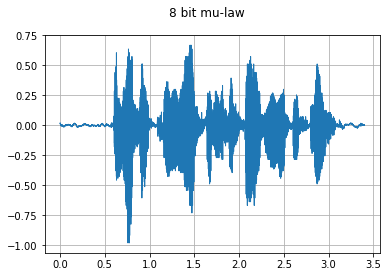

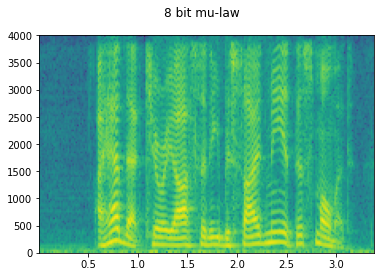

In [22]:
plot_waveform(waveforms[0], sample_rate, title="8 bit mu-law")
plot_specgram(waveforms[0], sample_rate, title="8 bit mu-law")
Audio(waveforms[0], rate=sample_rate)

### GSM-FR:




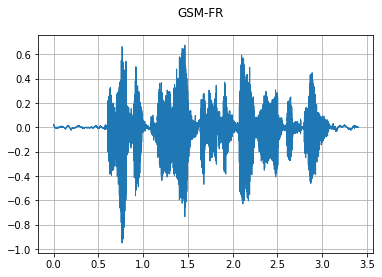

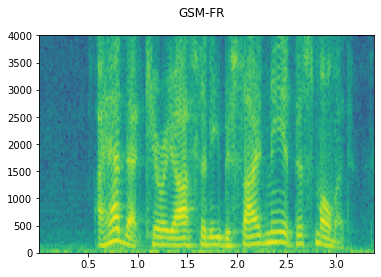

In [23]:
plot_waveform(waveforms[1], sample_rate, title="GSM-FR")
plot_specgram(waveforms[1], sample_rate, title="GSM-FR")
Audio(waveforms[1], rate=sample_rate)

### Vorbis:




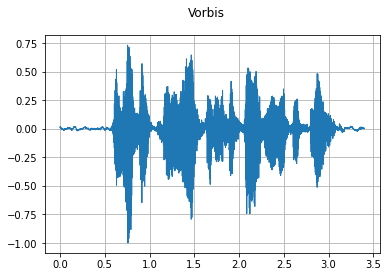

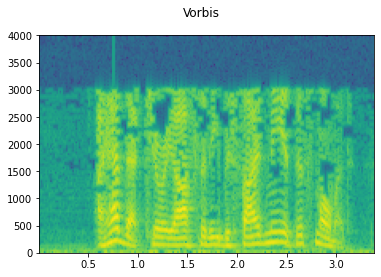

In [24]:
plot_waveform(waveforms[2], sample_rate, title="Vorbis")
plot_specgram(waveforms[2], sample_rate, title="Vorbis")
Audio(waveforms[2], rate=sample_rate)

## Bir telefon kaydını simüle etme

Önceki teknikleri birleştirerek, kulağa hoş gelen sesi simüle edebiliriz.
Arka planda insanların konuştuğu yankılı bir odada telefonla konuşan bir kişi gibi..





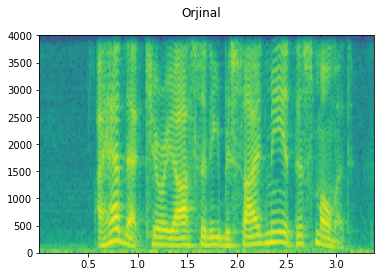

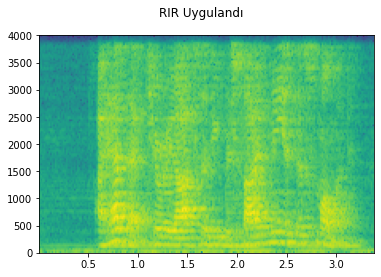

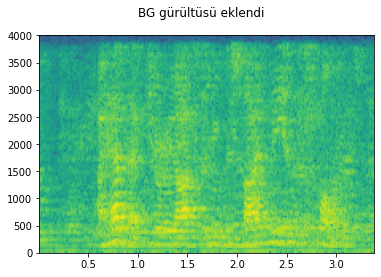

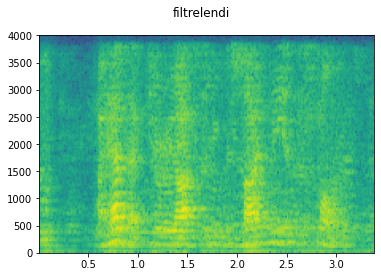

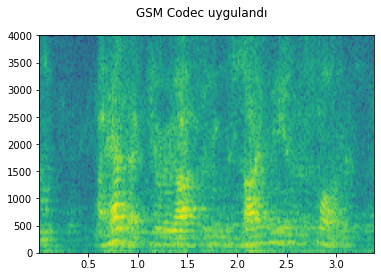

In [25]:
sample_rate = 16000
original_speech, sample_rate = torchaudio.load(SAMPLE_SPEECH)

plot_specgram(original_speech, sample_rate, title="Orjinal")

# RIR uygulayalım.
speech_ = torch.nn.functional.pad(original_speech, (RIR.shape[1] - 1, 0))
rir_applied = torch.nn.functional.conv1d(speech_[None, ...], RIR[None, ...])[0]

plot_specgram(rir_applied, sample_rate, title="RIR Uygulandı")

# Arka plan gürültüsü ekleyin
# Gürültü gerçek ortamda kaydedildiğinden,
# gürültü ortamın akustik özelliğini içerir. Bu nedenle, 
# RIR uygulamasından sonraki gürültüyü ekliyoruz
noise, _ = torchaudio.load(SAMPLE_NOISE)
noise = noise[:, : rir_applied.shape[1]]

snr_db = 8
scale = (10 ** (snr_db / 20)) * noise.norm(p=2) / rir_applied.norm(p=2)
bg_added = (scale * rir_applied + noise) / 2

plot_specgram(bg_added, sample_rate, title="BG gürültüsü eklendi")

# Filtreleme uygulayın ve örnekleme hızını değiştirin
filtered, sample_rate2 = torchaudio.sox_effects.apply_effects_tensor(
    bg_added,
    sample_rate,
    effects=[
        ["lowpass", "4000"],
        [
            "compand",
            "0.02,0.05",
            "-60,-60,-30,-10,-20,-8,-5,-8,-2,-8",
            "-8",
            "-7",
            "0.05",
        ],
        ["rate", "8000"],
    ],
)

plot_specgram(filtered, sample_rate2, title="filtrelendi")

# Telefon codec bileşenini uygula
codec_applied = F.apply_codec(filtered, sample_rate2, format="gsm")

plot_specgram(codec_applied, sample_rate2, title="GSM Codec uygulandı")

### Original konuşma:




In [26]:
Audio(original_speech, rate=sample_rate)

### RIR uygulanmış hali:




In [27]:
Audio(rir_applied, rate=sample_rate)

### arka plan gürültüsü eklenmiş hali:




In [28]:
Audio(bg_added, rate=sample_rate)

### filtrelendi:




In [29]:
Audio(filtered, rate=sample_rate2)

### Codec uygulandı:




In [30]:
Audio(codec_applied, rate=sample_rate2)